<a href="https://colab.research.google.com/github/shohan007/ML-Engineered-Tissue-Evaluation/blob/main/DIS_GelMA_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
%matplotlib inline
from matplotlib import pyplot as plt


In [2]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Activation, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from imutils import paths

In [ ]:
tf.__version__

'2.4.1'

In [7]:
df=pd.read_excel('/content/drive/MyDrive/DIS Data/DIS final datasheet for Gelma Paper.xlsx')
X=df[['174kHz', '224kHz', '287kHz', '368kHz', '473kHz', '607kHz', '779kHz', '1000kHz', '1284kHz', '1648kHz', '2115kHz']]
Y=df[['Cell Type','Time Period (in hour)','Cell Quantity (in Million)']]
df

,Events,174kHz,224kHz,287kHz,368kHz,473kHz,607kHz,779kHz,1000kHz,1284kHz,1648kHz,2115kHz,Cell Type,Time Period (in hour),Cell Quantity (in Million),Cell Type in Digit
0,Feed,1.331,1.207,0.562,0.745,0.594,0.360,0.247,0.279,0.045,0.148,0.058,MG63,24,1.0,1
1,0,1.387,1.270,0.969,0.789,0.569,0.320,0.264,0.244,0.095,0.174,0.047,MG63,24,1.0,1
2,0,1.344,1.297,0.736,0.825,0.592,0.307,0.249,0.167,0.024,0.149,-0.029,MG63,24,1.0,1
3,0,1.305,1.183,0.661,0.705,0.524,0.306,0.273,0.184,0.054,0.071,-0.011,MG63,24,1.0,1
4,0,1.345,1.052,0.692,0.787,0.577,0.359,0.263,0.265,0.031,0.102,-0.020,MG63,24,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3234,0,2.655,2.462,2.068,1.582,1.225,1.610,1.421,1.405,1.115,1.147,1.146,c2c12,96,2.0,4
3235,0,2.857,2.431,2.206,1.579,1.450,1.495,1.383,1.353,1.082,1.118,1.173,c2c12,96,2.0,4
3236,0,2.783,2.487,2.094,1.678,1.505,1.573,1.362,1.367,1.150,1.098,1.166,c2c12,96,2.0,4
3237,0,2.965,2.277,2.015,1.671,1.385,1.518,1.339,1.440,1.131,1.105,1.156,c2c12,96,2.0,4


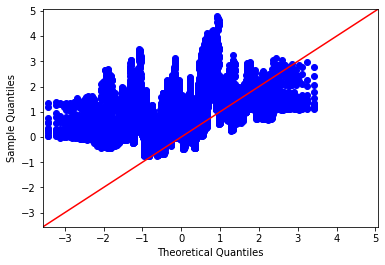

In [11]:
import statsmodels.api as sm
import pylab as py

outlier=df['2115kHz'].idxmax()
df.drop(index=outlier,inplace=True)
df.head()

sm.qqplot(df.iloc[:,1:12], line ='45')
py.show()

In [ ]:
#Choosing Proper Cell Name
df['Cell Type'] = df['Cell Type'].str.replace('c2c12','C2C12')
df['Cell Type'] = df['Cell Type'].str.replace('3T3','NIH 3T3')
df['Cell Type'] = df['Cell Type'].str.replace('Chondro','Human Chondrocyte')
df['Cell Type'] = df['Cell Type'].str.replace('chondro','Human Chondrocyte')

In [ ]:
df['Cell Type'].value_counts()

C2C12                          1079
NIH NIH 3T3                     720
Human Human Chondrocytecyte     720
MG63                            720
Name: Cell Type, dtype: int64

In [ ]:
#Encoding the categorical Y
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
lb1=LabelBinarizer()
lb2=LabelBinarizer()
lb3=LabelBinarizer()
scaler=StandardScaler()
Y['Cell Quantity (in Million)']=Y['Cell Quantity (in Million)'].astype(int)
X_transformed=scaler.fit_transform(X)
Y_transformed_cell_type_ann = lb1.fit_transform(Y['Cell Type'])
Y_transformed_time_ann=lb2.fit_transform(Y['Time Period (in hour)'])
Y_transformed_quantity_ann=lb3.fit_transform(Y['Cell Quantity (in Million)'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#Classification for Time Period

In [ ]:
# split the dataset
trainx, testx, trainy, testy = train_test_split(X_transformed,
                                                Y_transformed_time_ann,
                                                test_size=0.3,
                                                random_state=42)

In [ ]:

# create the ANN model - time
model = Sequential()
model.add(Dense(units=16, input_shape=(X_transformed.shape[1],)))
model.add(Activation("relu"))
# model.add(Dense(units=16))
# model.add(Activation("relu"))
model.add(Dense(units=12))
model.add(Activation("relu"))
model.add(Dense(units=len(lb2.classes_)))
model.add(Activation("softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                192       
_________________________________________________________________
activation (Activation)      (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                204       
_________________________________________________________________
activation_1 (Activation)    (None, 12)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 52        
_________________________________________________________________
activation_2 (Activation)    (None, 4)                 0         
Total params: 448
Trainable params: 448
Non-trainable params: 0
__________________________________________________________

In [ ]:
# init some global variables
epochs = 1000
init_lr = 1e-3


# compile the model and start training
opt = Adam(learning_rate=init_lr, decay=init_lr/epochs)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

H = model.fit(trainx, trainy,
              validation_data=(testx, testy),
              verbose=1,
              epochs=epochs)

Epoch 1/1000
71/71 [==============================] - 1s 7ms/step - loss: 1.4405 - accuracy: 0.2980 - val_loss: 1.2810 - val_accuracy: 0.4208
Epoch 2/1000
71/71 [==============================] - 0s 2ms/step - loss: 1.2535 - accuracy: 0.4472 - val_loss: 1.1938 - val_accuracy: 0.5206
Epoch 3/1000
71/71 [==============================] - 0s 2ms/step - loss: 1.1653 - accuracy: 0.5326 - val_loss: 1.1162 - val_accuracy: 0.5648
Epoch 4/1000
71/71 [==============================] - 0s 2ms/step - loss: 1.0909 - accuracy: 0.5716 - val_loss: 1.0460 - val_accuracy: 0.5874
Epoch 5/1000
71/71 [==============================] - 0s 2ms/step - loss: 1.0272 - accuracy: 0.5942 - val_loss: 0.9948 - val_accuracy: 0.6029
Epoch 6/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.9684 - accuracy: 0.6021 - val_loss: 0.9545 - val_accuracy: 0.6152
Epoch 7/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.9355 - accuracy: 0.6066 - val_loss: 0.9247 - val_accuracy: 0.6214
Epoch 

 Building the ANN

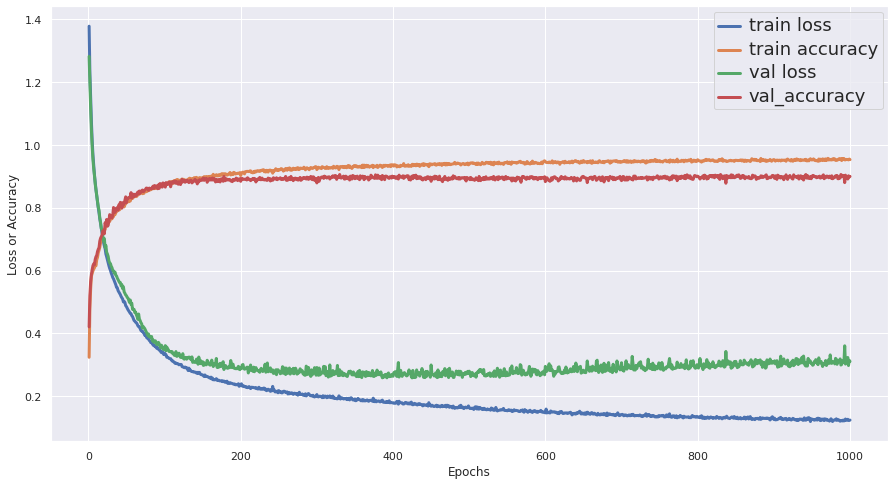

In [ ]:
# plot the performance
epoch_num = range(1,epochs+1)
loss = H.history['loss']
accuracy = H.history['accuracy']
val_loss = H.history['val_loss']
val_accuracy = H.history['val_accuracy']
plot_df = pd.DataFrame(data=np.c_[epoch_num,
                                  loss,accuracy,
                                  val_loss,
                                  val_accuracy],
                       columns=['epochs','loss', 'accuracy', 'val_loss', 'val_accuracy'])

# do the actual plots
sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(15,8))
sns.lineplot(data=plot_df, x='epochs', y='loss', ax=ax, label='train loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='accuracy', ax=ax, label='train accuracy', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_loss', ax=ax, label='val loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_accuracy', ax=ax, label='val_accuracy', linewidth=3)
ax.set_ylabel('Loss or Accuracy')
ax.set_xlabel('Epochs')
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text

In [ ]:
# calculate the classification report
from sklearn.metrics import classification_report
preds = model.predict(testx)
print(classification_report(testy.argmax(axis=1),
                            preds.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       240
           1       0.87      0.89      0.88       255
           2       0.94      0.86      0.90       226
           3       0.90      0.92      0.91       251

    accuracy                           0.90       972
   macro avg       0.90      0.90      0.90       972
weighted avg       0.90      0.90      0.90       972



#Classification for cell type

In [ ]:
# split the dataset
trainx, testx, trainy, testy = train_test_split(X_transformed,
                                                Y_transformed_cell_type_ann,
                                                test_size=0.3,
                                                random_state=42)

In [ ]:

# create the ANN model - time
model = Sequential()
model.add(Dense(units=16, input_shape=(X_transformed.shape[1],)))
model.add(Activation("relu"))
# model.add(Dense(units=16))
# model.add(Activation("relu"))
model.add(Dense(units=12))
model.add(Activation("relu"))
model.add(Dense(units=len(lb1.classes_)))
model.add(Activation("softmax"))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 16)                192       
_________________________________________________________________
activation_9 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 12)                204       
_________________________________________________________________
activation_10 (Activation)   (None, 12)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 65        
_________________________________________________________________
activation_11 (Activation)   (None, 5)                 0         
Total params: 461
Trainable params: 461
Non-trainable params: 0
________________________________________________________

In [ ]:
# init some global variables
epochs = 1000
init_lr = 1e-3


# compile the model and start training
opt = Adam(learning_rate=init_lr, decay=init_lr/epochs)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

H = model.fit(trainx, trainy,
              validation_data=(testx, testy),
              verbose=1,
              epochs=epochs)

Epoch 1/1000
71/71 [==============================] - 1s 5ms/step - loss: 1.5921 - accuracy: 0.2479 - val_loss: 1.3276 - val_accuracy: 0.4475
Epoch 2/1000
71/71 [==============================] - 0s 2ms/step - loss: 1.2949 - accuracy: 0.4586 - val_loss: 1.2385 - val_accuracy: 0.4938
Epoch 3/1000
71/71 [==============================] - 0s 2ms/step - loss: 1.2109 - accuracy: 0.4749 - val_loss: 1.1513 - val_accuracy: 0.4990
Epoch 4/1000
71/71 [==============================] - 0s 2ms/step - loss: 1.1378 - accuracy: 0.4938 - val_loss: 1.1096 - val_accuracy: 0.5298
Epoch 5/1000
71/71 [==============================] - 0s 2ms/step - loss: 1.0854 - accuracy: 0.5398 - val_loss: 1.0806 - val_accuracy: 0.5545
Epoch 6/1000
71/71 [==============================] - 0s 3ms/step - loss: 1.0585 - accuracy: 0.5862 - val_loss: 1.0494 - val_accuracy: 0.5586
Epoch 7/1000
71/71 [==============================] - 0s 2ms/step - loss: 1.0344 - accuracy: 0.5941 - val_loss: 1.0143 - val_accuracy: 0.5689
Epoch 

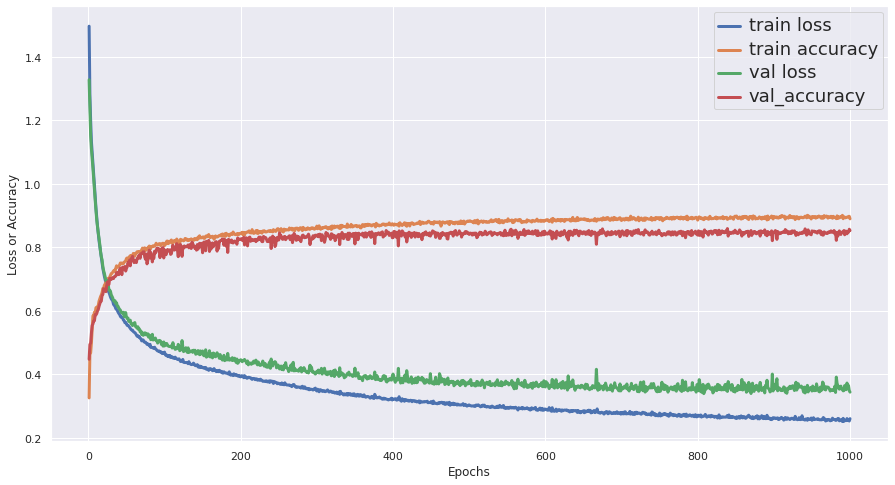

In [ ]:
# plot the performance
epoch_num = range(1,epochs+1)
loss = H.history['loss']
accuracy = H.history['accuracy']
val_loss = H.history['val_loss']
val_accuracy = H.history['val_accuracy']
plot_df = pd.DataFrame(data=np.c_[epoch_num,
                                  loss,accuracy,
                                  val_loss,
                                  val_accuracy],
                       columns=['epochs','loss', 'accuracy', 'val_loss', 'val_accuracy'])

# do the actual plots
sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(15,8))
sns.lineplot(data=plot_df, x='epochs', y='loss', ax=ax, label='train loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='accuracy', ax=ax, label='train accuracy', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_loss', ax=ax, label='val loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_accuracy', ax=ax, label='val_accuracy', linewidth=3)
ax.set_ylabel('Loss or Accuracy')
ax.set_xlabel('Epochs')
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text

In [ ]:
# calculate the classification report
from sklearn.metrics import classification_report
preds = model.predict(testx)
print(classification_report(testy.argmax(axis=1),
                            preds.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.76      0.70      0.73       209
           1       0.78      0.84      0.81       161
           2       0.81      0.80      0.81       238
           3       0.96      0.99      0.98       328
           4       0.94      0.86      0.90        36

    accuracy                           0.85       972
   macro avg       0.85      0.84      0.84       972
weighted avg       0.85      0.85      0.85       972



#Classification for Cell volume

In [ ]:
# split the dataset
trainx, testx, trainy, testy = train_test_split(X_transformed,
                                                Y_transformed_quantity_ann,
                                                test_size=0.3,
                                                random_state=42)

In [ ]:

# create the ANN model - time
model = Sequential()
model.add(Dense(units=16, input_shape=(X_transformed.shape[1],)))
model.add(Activation("relu"))
# model.add(Dense(units=16))
# model.add(Activation("relu"))
model.add(Dense(units=12))
model.add(Activation("relu"))
model.add(Dense(units=len(lb3.classes_)))
model.add(Activation("softmax"))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 16)                192       
_________________________________________________________________
activation_12 (Activation)   (None, 16)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 12)                204       
_________________________________________________________________
activation_13 (Activation)   (None, 12)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 39        
_________________________________________________________________
activation_14 (Activation)   (None, 3)                 0         
Total params: 435
Trainable params: 435
Non-trainable params: 0
________________________________________________________

In [ ]:
# init some global variables
epochs = 1000
init_lr = 1e-3


# compile the model and start training
opt = Adam(learning_rate=init_lr, decay=init_lr/epochs)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

H = model.fit(trainx, trainy,
              validation_data=(testx, testy),
              verbose=1,
              epochs=epochs)

Epoch 1/1000
71/71 [==============================] - 1s 4ms/step - loss: 1.0499 - accuracy: 0.4277 - val_loss: 0.9750 - val_accuracy: 0.5010
Epoch 2/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.9910 - accuracy: 0.4727 - val_loss: 0.9387 - val_accuracy: 0.5267
Epoch 3/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.9289 - accuracy: 0.5460 - val_loss: 0.9076 - val_accuracy: 0.5885
Epoch 4/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.9233 - accuracy: 0.5630 - val_loss: 0.8858 - val_accuracy: 0.6152
Epoch 5/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.9063 - accuracy: 0.5873 - val_loss: 0.8691 - val_accuracy: 0.6101
Epoch 6/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.9017 - accuracy: 0.5763 - val_loss: 0.8551 - val_accuracy: 0.6307
Epoch 7/1000
71/71 [==============================] - 0s 2ms/step - loss: 0.8828 - accuracy: 0.5832 - val_loss: 0.8422 - val_accuracy: 0.6224
Epoch 

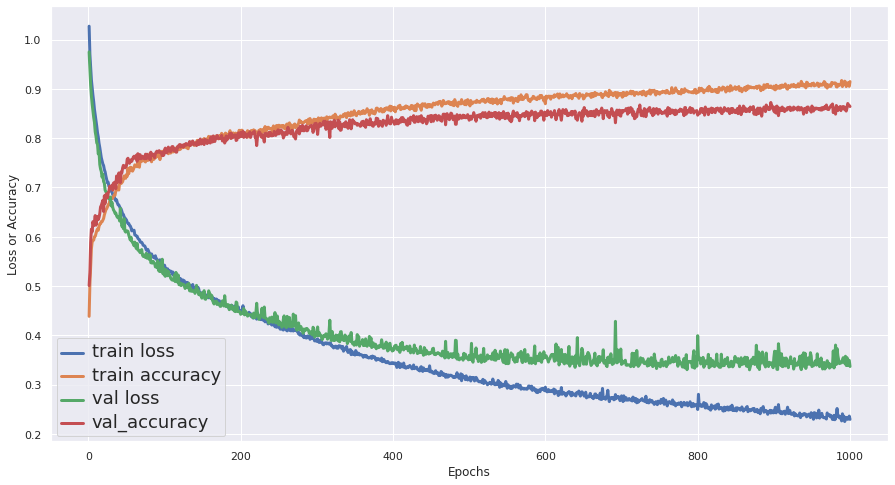

In [ ]:
# plot the performance
epoch_num = range(1,epochs+1)
loss = H.history['loss']
accuracy = H.history['accuracy']
val_loss = H.history['val_loss']
val_accuracy = H.history['val_accuracy']
plot_df = pd.DataFrame(data=np.c_[epoch_num,
                                  loss,accuracy,
                                  val_loss,
                                  val_accuracy],
                       columns=['epochs','loss', 'accuracy', 'val_loss', 'val_accuracy'])

# do the actual plots
sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(15,8))
sns.lineplot(data=plot_df, x='epochs', y='loss', ax=ax, label='train loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='accuracy', ax=ax, label='train accuracy', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_loss', ax=ax, label='val loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_accuracy', ax=ax, label='val_accuracy', linewidth=3)
ax.set_ylabel('Loss or Accuracy')
ax.set_xlabel('Epochs')
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text

In [ ]:
# calculate the classification report
from sklearn.metrics import classification_report
preds = model.predict(testx)
print(classification_report(testy.argmax(axis=1),
                            preds.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.88      0.89      0.88       305
           1       0.85      0.85      0.85       329
           2       0.87      0.86      0.86       338

    accuracy                           0.86       972
   macro avg       0.86      0.86      0.86       972
weighted avg       0.86      0.86      0.86       972

